In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:
#Reading the final df CSV file

refined_features_df = pd.read_csv('/kaggle/input/dynamic-pricing-refined-features/dynamic_pricing_refined_features_DF.csv')

In [3]:
refined_features_df.columns

Index(['seller_state_sp', 'seller_state_mg', 'seller_state_pr',
       'freight_value_log', 'seller_state_rj', 'seller_state_sc',
       'seller_city_sao_paulo', 'seller_state_rs', 'seller_city_curitiba',
       'seller_city_rio_de_janeiro', 'seller_city_belo_horizonte',
       'seller_city_maringa', 'seller_state_df', 'seller_city_brasilia',
       'seller_state_ba', 'seller_state_go', 'seller_city_porto_alegre',
       'seller_state_ma', 'seller_state_pe', 'seller_city_sao_luis',
       'seller_city_ibitinga', 'seller_city_petropolis', 'seller_state_es',
       'product_category_name_english_computers_accessories',
       'seller_city_joinville', 'seller_city_lauro_de_freitas',
       'seller_city_recife', 'seller_city_ilicinea',
       'product_category_name_english_health_beauty',
       'seller_city_borda_da_mata', 'seller_city_cariacica',
       'seller_city_brusque', 'seller_city_sao_goncalo',
       'seller_city_blumenau', 'product_category_name_english_bed_bath_table',
       

**Train-Test Split**

In [4]:
# Define features (X) and target (y)
X = refined_features_df.drop(columns=['regional_demand'])
y = refined_features_df['regional_demand']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (82251, 42)
Testing features shape: (20563, 42)
Training target shape: (82251,)
Testing target shape: (20563,)


**Initialize models**

In [5]:

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)
}

**Evaluate each model using cross-validation**

In [6]:
cv_results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_results[model_name] = {
        'Mean CV MAE': -np.mean(cv_scores),
        'Std Dev CV MAE': np.std(cv_scores),
        'Model': model
    }
    print(f"{model_name} - Mean CV MAE: {-np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Shortlist models based on CV performance
shortlisted_models = sorted(cv_results.items(), key=lambda x: x[1]['Mean CV MAE'])[:3]
print("\nShortlisted Models for Test Set Evaluation:", [model[0] for model in shortlisted_models])


Evaluating Linear Regression...
Linear Regression - Mean CV MAE: 0.0406 ± 0.0047
Evaluating Random Forest...
Random Forest - Mean CV MAE: 0.0194 ± 0.0044
Evaluating XGBoost...
XGBoost - Mean CV MAE: 1.4093 ± 0.0783
Evaluating LightGBM...
LightGBM - Mean CV MAE: 0.7570 ± 0.0028
Evaluating CatBoost...
CatBoost - Mean CV MAE: 8.5175 ± 1.0835

Shortlisted Models for Test Set Evaluation: ['Random Forest', 'Linear Regression', 'LightGBM']


**Evaluate shortlisted models on the test set**

In [7]:

test_results = {}
for model_name, model_data in shortlisted_models:
    model = model_data['Model']
    # Train on the full training set
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Evaluate metrics
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }
    test_results[model_name] = metrics
    print(f"\n{model_name} - Test Set Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Select the best model based on Test Set MAE
final_model_name = min(test_results, key=lambda x: test_results[x]['MAE'])
final_model = models[final_model_name]

print(f"\nFinal Selected Model: {final_model_name}")

# Save the selected model's test set performance
final_test_metrics = test_results[final_model_name]
print(f"\nFinal Model Test Set Metrics: {final_test_metrics}")


Random Forest - Test Set Performance:
MAE: 0.0170
MSE: 0.4651
R²: 1.0000

Linear Regression - Test Set Performance:
MAE: 0.0366
MSE: 0.4800
R²: 1.0000

LightGBM - Test Set Performance:
MAE: 0.7537
MSE: 1.0903
R²: 1.0000

Final Selected Model: Random Forest

Final Model Test Set Metrics: {'MAE': 0.016969110607818482, 'MSE': 0.46511518504840577, 'R²': 0.999999999502845}


**Analyze Overfitting, Feature Importance, and Diagnostics**


--- Learning Curve Analysis ---


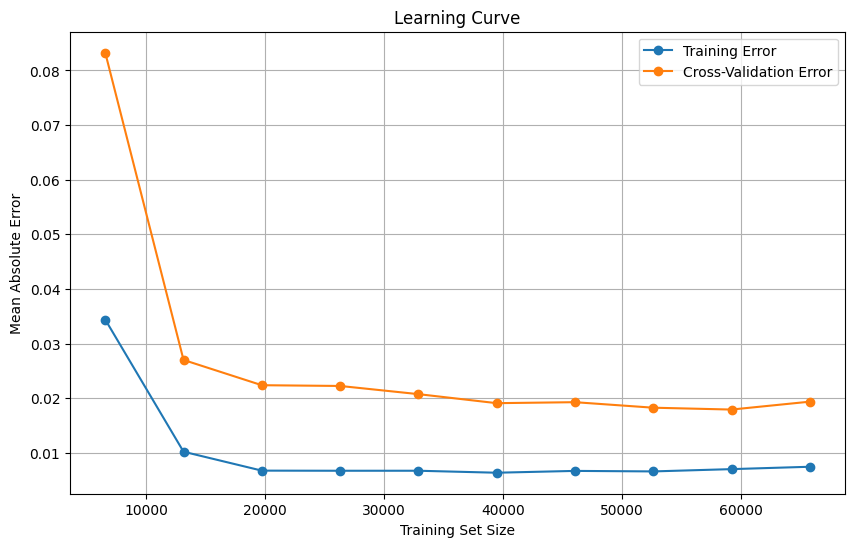


--- Feature Importance ---


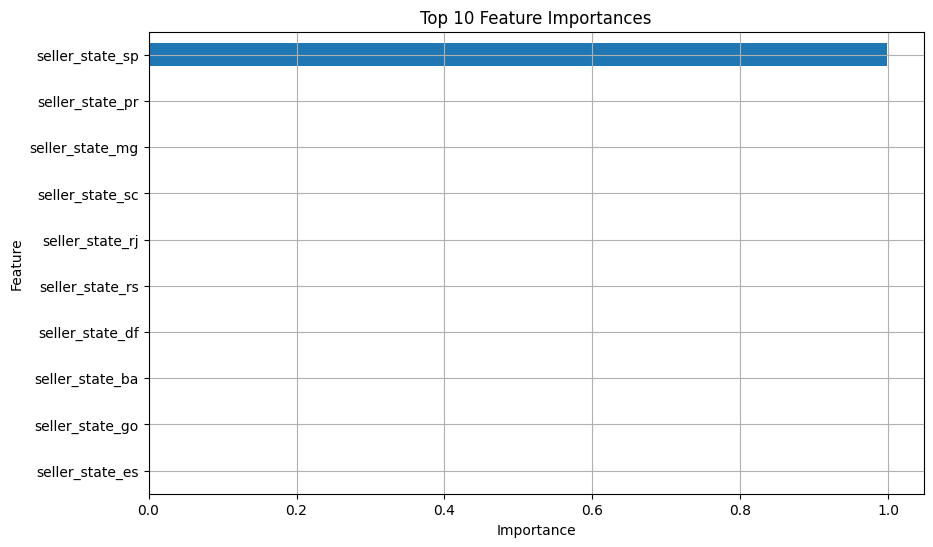


--- Checking Data Leakage ---

--- Correlation with Target ---
regional_demand                                 1.000000
seller_state_sp                                 0.998803
seller_city_sao_paulo                           0.365494
seller_city_ibitinga                            0.177310
product_category_name_english_bed_bath_table    0.126926
seller_city_santo_andre                         0.106603
product_category_name_english_telephony         0.069752
product_category_name_english_health_beauty    -0.039435
seller_state_ce                                -0.053179
seller_state_mt                                -0.064223
Name: regional_demand, dtype: float64

--- Test Set Performance ---
MAE: 0.0170
MSE: 0.4651
R²: 1.0000


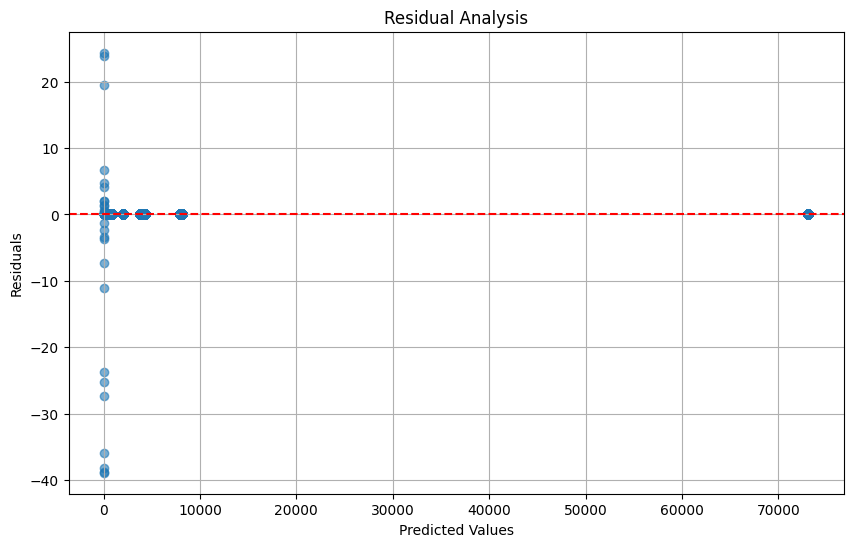

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming Random Forest is the final model
final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

# 1. Learning Curve Analysis
def plot_learning_curve(model, X, y, cv=5, scoring='neg_mean_absolute_error'):
    """
    Plots the learning curve for the given model.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
    plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Error', marker='o')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- Learning Curve Analysis ---")
plot_learning_curve(final_model, X_train, y_train)

# 2. Feature Importance Analysis (Tree-based model)
def plot_feature_importance(model, feature_names, top_n=10):
    """
    Plots the top N important features for tree-based models.
    """
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    feature_importance_df.plot(kind='barh', x='Feature', y='Importance', figsize=(10, 6), legend=False)
    plt.title(f"Top {top_n} Feature Importances")
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()

print("\n--- Feature Importance ---")
plot_feature_importance(final_model, X_train.columns)

# 3. Check for Data Leakage (Correlation with Target)
def check_data_leakage(df, target_column):
    """
    Checks for high correlations between features and the target, indicating potential leakage.
    """
    correlation_with_target = df.corr()[target_column].sort_values(ascending=False)
    print("\n--- Correlation with Target ---")
    print(correlation_with_target.head(10))  # Display top 10 correlations
    return correlation_with_target

# Check correlations in the training data
print("\n--- Checking Data Leakage ---")
correlations = check_data_leakage(pd.concat([X_train, y_train], axis=1), target_column='regional_demand')

# 4. Test Set Evaluation and Residual Analysis
y_pred_test = final_model.predict(X_test)

# Metrics
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
print(f"\n--- Test Set Performance ---")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# Residual Analysis
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Analysis')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


*Validating and Evaluating Random Forest Model*

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import shap
import matplotlib.pyplot as plt
import joblib

Skewness of Target Variable: -0.94
No significant skewness detected. Proceeding with original target.
Training Set: (61688, 42), Validation Set: (20563, 42), Test Set: (20563, 42)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Random Forest Parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Validation Set Performance: {'MAE': 0.1470427632552467, 'MAPE': 0.39373859188344373, 'MSE': 7.44526302636934, 'R²': 0.9999999920433312}


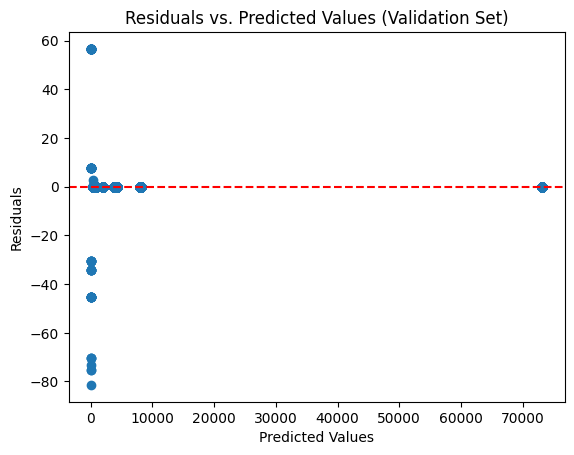

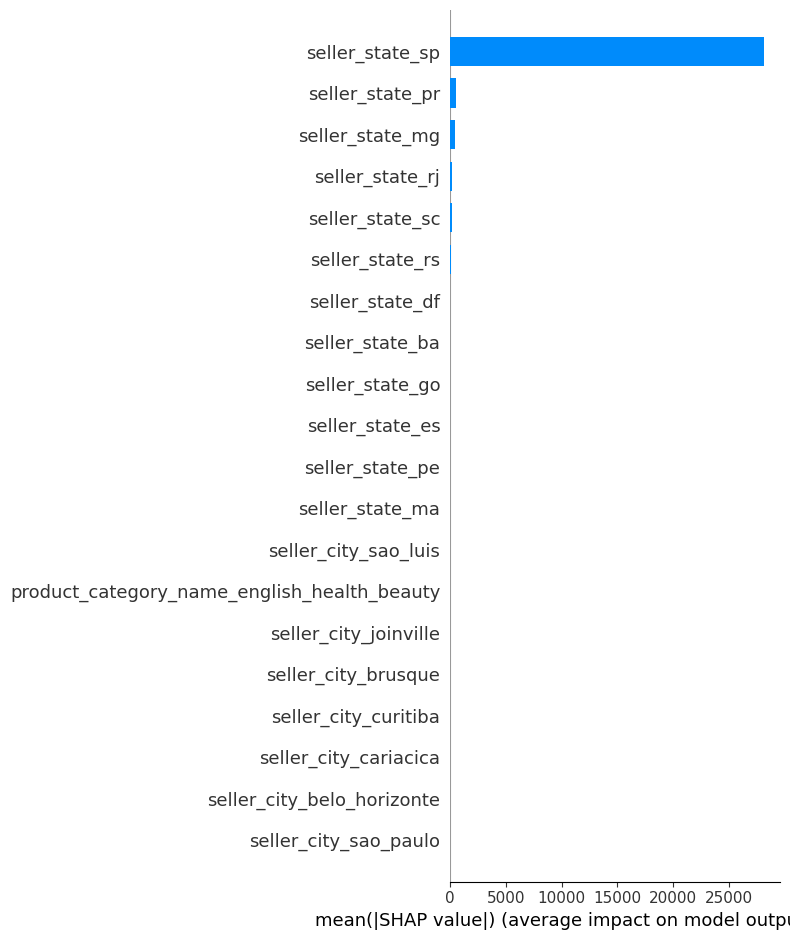

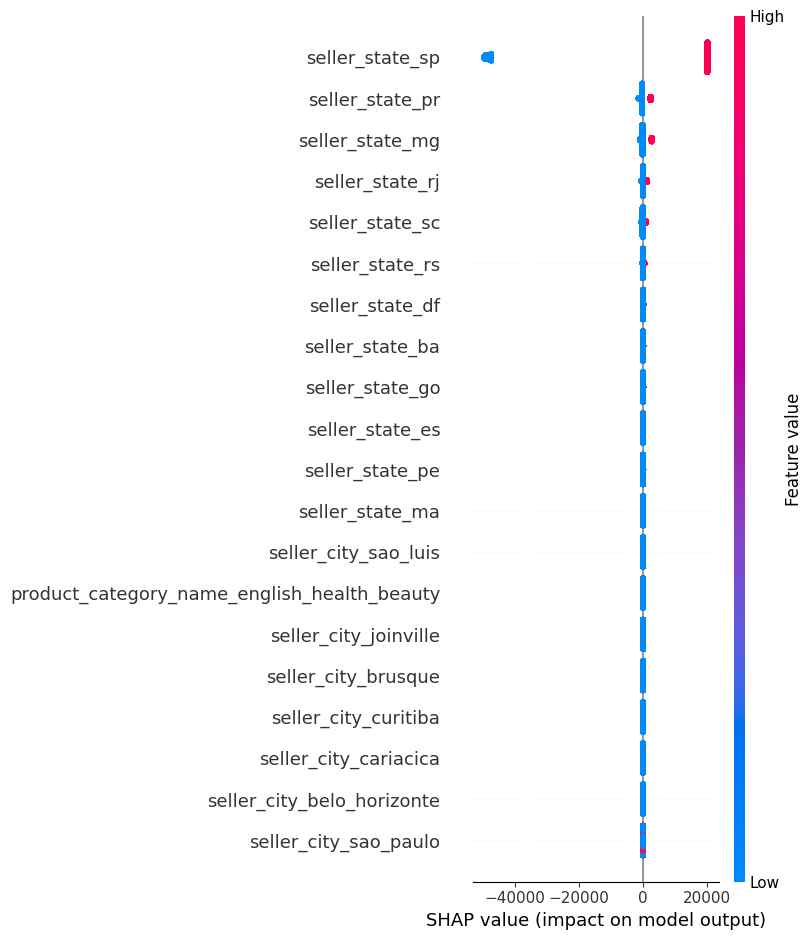

Test Set Performance: {'MAE': 0.1437728960520581, 'MAPE': 0.46962796440998944, 'MSE': 7.573366546388357, 'R²': 0.9999999919373314}
Final model saved as 'final_random_forest_model.pkl'.
Model metrics saved to 'model_metrics.txt'.


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
import joblib

# --- Evaluation Function ---
def evaluate_model(model, X, y, transform_func=None):
    predictions = model.predict(X)
    if transform_func:
        predictions = transform_func(predictions)
        y = transform_func(y)
    mae = mean_absolute_error(y, predictions)
    mape = np.mean(np.abs((y - predictions) / y)) * 100
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    return {'MAE': mae, 'MAPE': mape, 'MSE': mse, 'R²': r2}

# --- Add Noise to Dataset ---
def augment_data(X, noise_level=0.02):
    noisy_X = X.copy()
    for col in noisy_X.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_level * noisy_X[col].std(), noisy_X[col].shape)
        noisy_X[col] += noise
    return noisy_X

# --- Check Skewness and Transform ---
def check_and_transform_target(y):
    skewness = y.skew()
    print(f"Skewness of Target Variable: {skewness:.2f}")
    if abs(skewness) > 1:
        print("High skewness detected. Applying log transformation.")
        return np.log1p(y), np.expm1
    print("No significant skewness detected. Proceeding with original target.")
    return y, None

# --- Dataset Preparation ---
X = refined_features_df.drop(columns=['regional_demand'])
y, inverse_transform_func = check_and_transform_target(refined_features_df['regional_demand'])

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

# Augment training data with noise
X_train_augmented = augment_data(X_train, noise_level=0.02)

# --- Hyperparameter Tuning ---
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [2, 5]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_augmented, y_train)

best_rf_model = grid_search.best_estimator_
print(f"Best Random Forest Parameters: {grid_search.best_params_}")

# --- Evaluate on Validation Set ---
val_metrics = evaluate_model(best_rf_model, X_val, y_val, transform_func=inverse_transform_func)
print(f"Validation Set Performance: {val_metrics}")

# --- Residual Analysis ---
predictions = best_rf_model.predict(X_test)
if inverse_transform_func:
    predictions = inverse_transform_func(predictions)
    y_test = inverse_transform_func(y_test)

residuals = y_test - predictions
plt.scatter(predictions, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values (Validation Set)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# --- SHAP Explainability ---
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type='bar')
shap.summary_plot(shap_values, X_train)

# --- Final Test Evaluation ---
test_metrics = evaluate_model(best_rf_model, X_test, y_test, transform_func=None)
print(f"Test Set Performance: {test_metrics}")

# --- Save Model and Metrics ---
joblib.dump(best_rf_model, 'final_random_forest_model.pkl')
print("Final model saved as 'final_random_forest_model.pkl'.")

with open('model_metrics.txt', 'w') as f:
    f.write(f"Validation Metrics: {val_metrics}\n")
    f.write(f"Test Metrics: {test_metrics}\n")
print("Model metrics saved to 'model_metrics.txt'.")


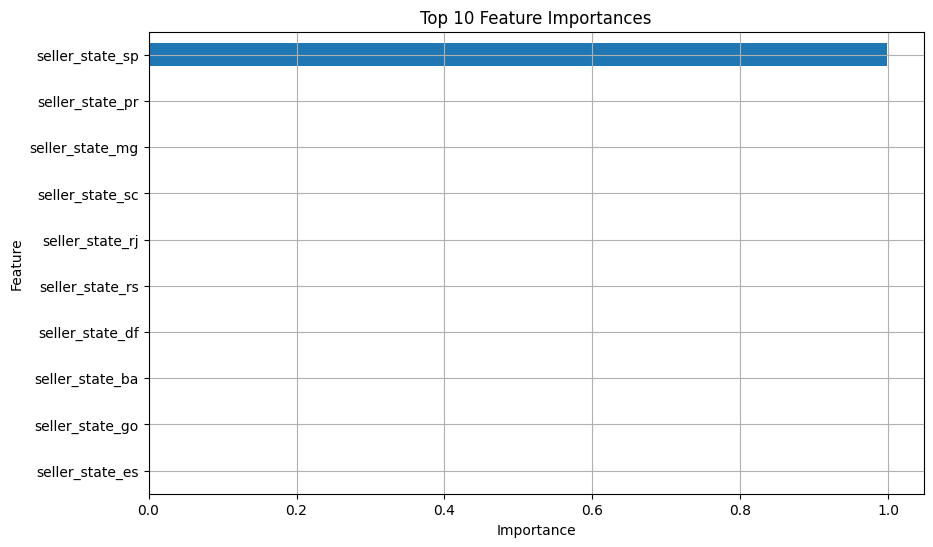

In [12]:
# Feature Importance Visualization
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
feature_importances[:10].plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.grid()
plt.show()
